# 09 — Undervalued Players & Dream Team

**Goal:** Apply the trained models to all players and surface recruitment opportunities.

**Inputs:** `../models/advanced_models.pkl` · `../data/processed/featured_{pos}.csv` · `preprocessors.pkl` · `final_features.json`

**Outputs:** `../data/processed/all_predictions.csv` · `../data/processed/dream_team.csv` · `../figures/09_*.png`

**Next:** `10_final_report_and_visualizations.ipynb`

---
**Logic:**
- Apply the same preprocessing pipeline (target encoding + StandardScaler) to **all** players using training-time statistics from `preprocessors.pkl` — no data leakage
- For players **with** a valuation: `undervaluation_ratio = predicted_€ / actual_€` — ratio > 1 means model values them higher than market
- For players **without** a valuation: predicted value only (hidden gems, scouting targets)
- **Dream team (4-3-3):** 1 GK + 4 DEF + 3 MID + 3 ATT, selected by highest `undervaluation_ratio` with ≥ 10 appearances

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

PROC_PATH    = '../data/processed/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)

POSITIONS = ['GK', 'DEF', 'MID', 'ATT']

# Dream team slots per position (4-3-3)
DREAM_SLOTS = {'GK': 1, 'DEF': 4, 'MID': 3, 'ATT': 3}

# Eligibility filters
# MIN_APPEARANCES: enough career data to be meaningful
# MAX_AGE: players must have remaining career value — not near retirement
MIN_APPEARANCES = 30
MAX_AGE = {'GK': 35, 'DEF': 32, 'MID': 32, 'ATT': 30}

print('Imports OK')
print(f'Eligibility: min {MIN_APPEARANCES} appearances | max age GK={MAX_AGE["GK"]}, DEF={MAX_AGE["DEF"]}, MID={MAX_AGE["MID"]}, ATT={MAX_AGE["ATT"]}')

## 1. Load Models & Preprocessors

In [2]:
with open(MODELS_PATH + 'advanced_models.pkl', 'rb') as f:
    models = pickle.load(f)

with open(PROC_PATH + 'preprocessors.pkl', 'rb') as f:
    preprocessors = pickle.load(f)

with open(PROC_PATH + 'final_features.json') as f:
    FINAL_FEATURES = json.load(f)

scalers          = preprocessors['scalers']
league_encodings = preprocessors['league_encodings']

# Load ALL featured players (not just labeled)
featured = {}
for pos in POSITIONS:
    featured[pos] = pd.read_csv(PROC_PATH + f'featured_{pos.lower()}.csv')
    n_total = len(featured[pos])
    n_val   = featured[pos]['market_value_in_eur'].notna().sum()
    print(f'  {pos}: {n_total:,} players  ({n_val:,} with valuation, {n_total-n_val:,} without)')

  GK: 3,745 players  (3,313 with valuation, 432 without)
  DEF: 10,714 players  (9,867 with valuation, 847 without)
  MID: 9,766 players  (8,976 with valuation, 790 without)
  ATT: 9,299 players  (8,554 with valuation, 745 without)


## 2. Preprocess All Players

Replicate the notebook 05 pipeline using **training-time** statistics only:
1. Target-encode `current_club_domestic_competition_id` with saved league map
2. Select `FINAL_FEATURES[pos]`
3. Scale with the saved `StandardScaler`

In [3]:
CAT_COL = 'current_club_domestic_competition_id'
ENC_COL = 'league_mean_value'

X_all = {}

for pos in POSITIONS:
    df     = featured[pos].copy()
    enc    = league_encodings[pos]
    scaler = scalers[pos]
    feats  = FINAL_FEATURES[pos]

    # 1. Target-encode league (unseen leagues → global train mean)
    df[ENC_COL] = df[CAT_COL].map(enc['map']).fillna(enc['global_mean'])

    # 2. Select & fill remaining NaN with 0
    X = df[feats].fillna(0)

    # 3. Scale — transform only, no fit
    X_all[pos] = pd.DataFrame(scaler.transform(X), columns=feats, index=df.index)

    print(f'  {pos}: {X_all[pos].shape[0]:,} × {X_all[pos].shape[1]} preprocessed')

  GK: 3,745 × 18 preprocessed
  DEF: 10,714 × 19 preprocessed
  MID: 9,766 × 18 preprocessed
  ATT: 9,299 × 19 preprocessed


## 3. Generate Predictions for All Players

In [4]:
predictions = {}

for pos in POSITIONS:
    df       = featured[pos].copy()
    pred_log = models[pos].predict(X_all[pos])
    pred_eur = np.expm1(pred_log)

    df['pred_log']   = pred_log
    df['pred_eur']   = pred_eur
    df['pred_eur_M'] = pred_eur / 1e6

    # Undervaluation metrics — only for players with actual valuations
    has_val = df['market_value_in_eur'].notna()
    df.loc[has_val, 'underval_ratio'] = (
        df.loc[has_val, 'pred_eur'] / df.loc[has_val, 'market_value_in_eur']
    )
    df.loc[has_val, 'value_gap_M'] = (
        (df.loc[has_val, 'pred_eur'] - df.loc[has_val, 'market_value_in_eur']) / 1e6
    )

    predictions[pos] = df
    n_buy = (df.loc[has_val, 'underval_ratio'] > 1.5).sum()
    print(f'  {pos}: {n_buy:,} players with underval_ratio > 1.5 (predicted ≥ 50% above market)')

  GK: 669 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  DEF: 1,864 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  MID: 1,721 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  ATT: 1,786 players with underval_ratio > 1.5 (predicted ≥ 50% above market)


## 4. Top Undervalued Players per Position

Ranked by `undervaluation_ratio`. Eligibility: must have a valuation + ≥ 30 appearances + age ≤ MAX_AGE per position.
Age ceiling ensures we surface players with **remaining career value**, not retiring players priced at near-zero.

In [ ]:
TOP_N   = 15
DISPLAY = ['name', 'age', 'market_value_m', 'pred_eur_M', 'underval_ratio',
           'value_gap_M', 'total_appearances', 'current_club_domestic_competition_id']

top_undervalued = {}

for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos]) &
        (df['underval_ratio'] > 1.0)
    )
    top = df[mask].nlargest(TOP_N, 'underval_ratio')[DISPLAY].copy()
    top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']] = \
        top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']].round(2)
    top_undervalued[pos] = top

    print(f'\n{pos} — Top {TOP_N} most undervalued (age ≤ {MAX_AGE[pos]}, appearances ≥ {MIN_APPEARANCES}):')
    print(top.to_string(index=False))

## 5. Top Overvalued Players per Position

Model values them significantly below market — candidates to sell or avoid buying.

In [ ]:
for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos]) &
        (df['underval_ratio'] < 1.0)
    )
    top = df[mask].nsmallest(10, 'underval_ratio')[DISPLAY].copy()
    top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']] = \
        top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']].round(2)

    print(f'\n{pos} — Top 10 most overvalued (age ≤ {MAX_AGE[pos]}, appearances ≥ {MIN_APPEARANCES}):')
    print(top.to_string(index=False))

## 6. Hidden Gems — Players Without a Valuation

No Transfermarkt record exists for these players. The model's prediction is the only signal
of their potential worth — useful for scouting lower leagues and uncontracted players.

In [ ]:
GEM_COLS = ['name', 'age', 'pred_eur_M', 'total_appearances',
            'current_club_domestic_competition_id']

for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].isna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos])
    )
    gems = df[mask].nlargest(10, 'pred_eur_M')[GEM_COLS].copy()
    gems['pred_eur_M'] = gems['pred_eur_M'].round(2)

    print(f'\n{pos} — Top 10 unvalued players by predicted worth (age ≤ {MAX_AGE[pos]}, appearances ≥ {MIN_APPEARANCES}):')
    print(gems.to_string(index=False))

## 7. Undervaluation Bubble Chart

**X:** actual value · **Y:** predicted value · **Colour:** undervaluation category.
Points above the diagonal are undervalued; below are overvalued.

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, pos in zip(axes, POSITIONS):
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos])
    )
    d = df[mask].copy()

    actual_M = d['market_value_in_eur'] / 1e6
    pred_M   = d['pred_eur_M']
    ratio    = d['underval_ratio'].clip(0.2, 5)

    colors = np.where(d['underval_ratio'] >= 1.5, '#2ecc71',
             np.where(d['underval_ratio'] >= 1.0, '#3498db', '#e74c3c'))

    ax.scatter(actual_M, pred_M, s=ratio * 20, c=colors, alpha=0.4, linewidths=0)

    lim = max(actual_M.max(), pred_M.max()) * 1.05
    ax.plot([0, lim], [0, lim], 'k--', linewidth=1, alpha=0.5, label='Fair value')

    # Label top 3 undervalued
    for _, row in d.nlargest(3, 'underval_ratio').iterrows():
        ax.annotate(row['name'].split()[-1],
                    (row['market_value_in_eur']/1e6, row['pred_eur_M']),
                    fontsize=7, ha='left', color='#1a1a2e',
                    xytext=(4, 4), textcoords='offset points')

    green_p  = mpatches.Patch(color='#2ecc71', label='ratio ≥ 1.5×')
    blue_p   = mpatches.Patch(color='#3498db', label='1.0–1.5×')
    red_p    = mpatches.Patch(color='#e74c3c', label='< 1.0×')
    ax.legend(handles=[green_p, blue_p, red_p], fontsize=7, loc='upper left')

    ax.set_xlabel('Actual Value (€M)', fontsize=9)
    ax.set_ylabel('Predicted Value (€M)', fontsize=9)
    ax.set_title(f'{pos}  (age ≤ {MAX_AGE[pos]})', fontsize=11, fontweight='bold')
    ax.set_xlim(0, lim); ax.set_ylim(0, lim)
    ax.grid(True, alpha=0.3)

fig.suptitle('Undervaluation Bubble Chart — Age-Filtered (eligible players only)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_undervaluation_bubble.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved 09_undervaluation_bubble.png')

## 8. Dream Team — 4-3-3

Best undervalued XI: highest `undervaluation_ratio` per position slot.

**Eligibility:** `total_appearances ≥ 30` · `age ≤ MAX_AGE[pos]` · has a current valuation.

Age ceiling per position: GK ≤ 35, DEF ≤ 32, MID ≤ 32, ATT ≤ 30. This ensures the squad consists of players with real remaining career value — not retiring veterans priced near zero.

In [ ]:
dream_team_rows = []

for pos in POSITIONS:
    df   = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos])
    )
    picks = df[mask].nlargest(DREAM_SLOTS[pos], 'underval_ratio')

    for _, row in picks.iterrows():
        dream_team_rows.append({
            'position_group': pos,
            'name':           row['name'],
            'age':            int(row['age']),
            'actual_value_M': round(row['market_value_m'], 2),
            'predicted_M':    round(row['pred_eur_M'], 2),
            'underval_ratio': round(row['underval_ratio'], 2),
            'value_gap_M':    round(row['value_gap_M'], 2),
            'appearances':    int(row['total_appearances']),
            'league':         row['current_club_domestic_competition_id'],
        })

dream_team = pd.DataFrame(dream_team_rows)
print(dream_team.to_string(index=False))
print(f'\nTotal actual cost : €{dream_team["actual_value_M"].sum():.2f}M')
print(f'Total predicted   : €{dream_team["predicted_M"].sum():.2f}M')

## 9. Dream Team — Pitch Visualisation

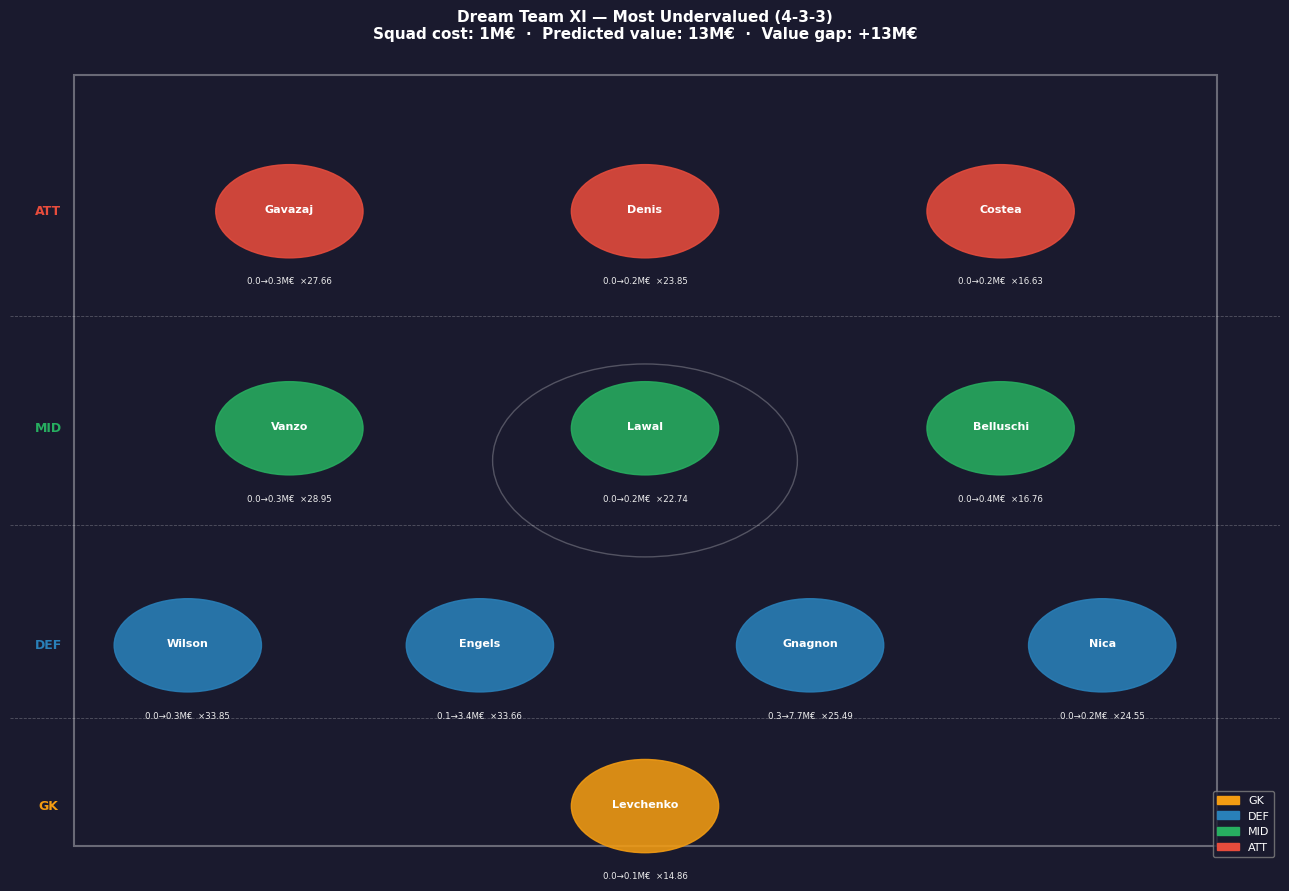

Saved.


In [10]:
fig, ax = plt.subplots(figsize=(13, 9))
ax.set_facecolor('#2d6a2d')
fig.patch.set_facecolor('#1a1a2e')

# Pitch markings
for y in [0.18, 0.42, 0.68]:
    ax.axhline(y, color='white', linewidth=0.6, alpha=0.25, linestyle='--')
ax.add_patch(plt.Rectangle((0.05, 0.02), 0.90, 0.96,
             fill=False, edgecolor='white', linewidth=1.5, alpha=0.35))
ax.add_patch(plt.Circle((0.5, 0.5), 0.12, fill=False,
             edgecolor='white', linewidth=1, alpha=0.25))

layout = {
    'GK':  [(0.50, 0.07)],
    'DEF': [(0.14, 0.27), (0.37, 0.27), (0.63, 0.27), (0.86, 0.27)],
    'MID': [(0.22, 0.54), (0.50, 0.54), (0.78, 0.54)],
    'ATT': [(0.22, 0.81), (0.50, 0.81), (0.78, 0.81)],
}
pos_colors = {'GK': '#f39c12', 'DEF': '#2980b9', 'MID': '#27ae60', 'ATT': '#e74c3c'}

for pos in POSITIONS:
    color   = pos_colors[pos]
    players = dream_team[dream_team['position_group'] == pos]
    for (x, y), (_, row) in zip(layout[pos], players.iterrows()):
        ax.add_patch(plt.Circle((x, y), 0.058, color=color, zorder=3, alpha=0.88))
        short = row['name'].split()[-1]
        ax.text(x, y + 0.002, short,
                ha='center', va='center', fontsize=8, fontweight='bold',
                color='white', zorder=4)
        ax.text(x, y - 0.082,
                f'{row["actual_value_M"]:.1f}→{row["predicted_M"]:.1f}M€  ×{row["underval_ratio"]:.2f}',
                ha='center', va='top', fontsize=6.2, color='#eeeeee', zorder=4)

# Position badges
for pos, (x, y) in [('GK',(0.03,0.07)),('DEF',(0.03,0.27)),
                     ('MID',(0.03,0.54)),('ATT',(0.03,0.81))]:
    ax.text(x, y, pos, ha='center', va='center', fontsize=9,
            fontweight='bold', color=pos_colors[pos])

ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title(
    f'Dream Team XI — Most Undervalued (4-3-3)\n'
    f'Squad cost: {total_cost:.0f}M€  ·  '
    f'Predicted value: {total_pred:.0f}M€  ·  '
    f'Value gap: +{total_gap:.0f}M€',
    color='white', fontsize=11, fontweight='bold', pad=14
)
handles = [mpatches.Patch(color=c, label=p) for p, c in pos_colors.items()]
ax.legend(handles=handles, loc='lower right', fontsize=8,
          facecolor='#1a1a2e', labelcolor='white', edgecolor='gray')

plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_dream_team_pitch.png', dpi=150,
            facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
print('Saved.')

## 10. Top 10 Undervalued per Position — Bar Chart

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, pos in zip(axes, POSITIONS):
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['age'] <= MAX_AGE[pos])
    )
    top10 = df[mask].nlargest(10, 'underval_ratio')[['name','market_value_m','pred_eur_M']].iloc[::-1]
    short = top10['name'].apply(lambda n: n.split()[-1] if ' ' in n else n)
    y     = np.arange(len(top10))

    ax.barh(y,       top10['pred_eur_M'],    height=0.4, color='#2ecc71', alpha=0.85, label='Predicted')
    ax.barh(y - 0.4, top10['market_value_m'], height=0.4, color='#3498db', alpha=0.85, label='Actual')
    ax.set_yticks(y - 0.2)
    ax.set_yticklabels(short, fontsize=8)
    ax.set_xlabel('Value (€M)')
    ax.set_title(f'{pos}  (age ≤ {MAX_AGE[pos]})')
    ax.legend(fontsize=8)
    ax.grid(True, axis='x', alpha=0.3)

fig.suptitle('Top 10 Undervalued Players per Position — Age-Filtered',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_top_undervalued_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved 09_top_undervalued_bar.png')

## 11. Validation

In [ ]:
errors = []

for pos in POSITIONS:
    df = predictions[pos]

    # 1. All predictions finite
    if not np.isfinite(df['pred_eur']).all():
        errors.append(f'{pos}: non-finite predictions')
    else:
        print(f'✓  {pos}: all {len(df):,} predictions finite')

    # 2. No negative predictions
    if (df['pred_eur'] < 0).any():
        errors.append(f'{pos}: negative predicted values')
    else:
        print(f'✓  {pos}: no negative predictions')

    # 3. Dream team slot filled correctly
    n_dt = (dream_team['position_group'] == pos).sum()
    if n_dt != DREAM_SLOTS[pos]:
        errors.append(f'{pos}: dream team has {n_dt} players, expected {DREAM_SLOTS[pos]}')
    else:
        print(f'✓  {pos}: dream team slot OK ({n_dt}/{DREAM_SLOTS[pos]})')

    # 4. Dream team players meet eligibility criteria
    dt_pos = dream_team[dream_team['position_group'] == pos]
    age_ok  = (dt_pos['age'] <= MAX_AGE[pos]).all()
    app_ok  = (dt_pos['appearances'] >= MIN_APPEARANCES).all()
    if not age_ok:
        errors.append(f'{pos}: dream team player exceeds MAX_AGE={MAX_AGE[pos]}')
    else:
        print(f'✓  {pos}: all dream team players age ≤ {MAX_AGE[pos]}')
    if not app_ok:
        errors.append(f'{pos}: dream team player below MIN_APPEARANCES={MIN_APPEARANCES}')
    else:
        print(f'✓  {pos}: all dream team players appearances ≥ {MIN_APPEARANCES}')

if errors:
    print('\nFAILED:')
    for e in errors: print(f'  ✗ {e}')
else:
    print('\n✓  All checks passed')

## 12. Save Outputs

In [13]:
SAVE_COLS = ['player_id', 'name', 'age', 'position_group', 'position',
             'market_value_m', 'pred_eur_M', 'underval_ratio', 'value_gap_M',
             'total_appearances', 'current_club_domestic_competition_id']

all_preds = pd.concat(
    [predictions[pos][[c for c in SAVE_COLS if c in predictions[pos].columns]]
     for pos in POSITIONS],
    ignore_index=True
)
all_preds.to_csv(PROC_PATH + 'all_predictions.csv', index=False)
dream_team.to_csv(PROC_PATH + 'dream_team.csv', index=False)

print(f'Saved all_predictions.csv — {len(all_preds):,} players')
print(f'Saved dream_team.csv      — {len(dream_team)} players')
print()
print('Figures:')
for f in sorted(os.listdir(FIGURES_PATH)):
    if f.startswith('09_'):
        print(f'  {f}')

Saved all_predictions.csv — 33,524 players
Saved dream_team.csv      — 11 players

Figures:
  09_dream_team_pitch.png
  09_top_undervalued_bar.png
  09_undervaluation_bubble.png
